In [1]:
#Notebook Setup
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/ADME_public_set_3521.csv")
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3521 entries, 0 to 3520
Data columns (total 10 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Internal ID                                     3521 non-null   object 
 1   Vendor ID                                       3521 non-null   object 
 2   SMILES                                          3521 non-null   object 
 3   CollectionName                                  3521 non-null   object 
 4   LOG HLM_CLint (mL/min/kg)                       3087 non-null   float64
 5   LOG MDR1-MDCK ER (B-A/A-B)                      2642 non-null   float64
 6   LOG SOLUBILITY PH 6.8 (ug/mL)                   2173 non-null   float64
 7   LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)  194 non-null    float64
 8   LOG PLASMA PROTEIN BINDING (RAT) (% unbound)    168 non-null    float64
 9   LOG RLM_CLint (mL/min/kg)                

,LOG HLM_CLint (mL/min/kg),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG RLM_CLint (mL/min/kg)
count,3087.000000,2642.000000,2173.000000,194.000000,168.000000,3054.000000
mean,1.320019,0.397829,1.259943,0.765722,0.764177,2.256207
std,0.623952,0.688465,0.683416,0.847902,0.798988,0.750422
min,0.675687,-1.162425,-1.000000,-1.593460,-1.638272,1.027920
25%,0.675687,-0.162356,1.153510,0.168067,0.226564,1.688291
50%,1.205313,0.153291,1.542825,0.867555,0.776427,2.311068
75%,1.803115,0.905013,1.687351,1.501953,1.375962,2.835274
max,3.372714,2.725057,2.179264,2.000000,2.000000,3.969622


- The dataset contains 3521 compounds with 10 columns.
- Non-numeric comlumns are (Internal ID, Vendor ID, SMILES, CollectionName)
  are fully populated and uniquely identify each compound.
- ADME assay data show varying levels of completeness, with clearance
  endpoints having broader coverage than solubility and plasma protein
  binding measurements.

In [2]:
df['Vendor ID'].nunique()

3521

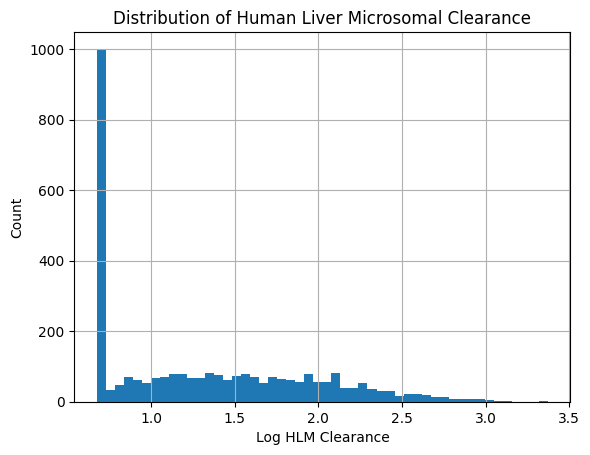

In [3]:
df['LOG HLM_CLint (mL/min/kg)'].hist(bins=50)
plt.xlabel('Log HLM Clearance')
plt.ylabel('Count')
plt.title('Distribution of Human Liver Microsomal Clearance')
plt.show()

Matplotlib automatically excludes compounds with missing clearance values, so only rows with available HLM measurements are shown.

### Apparent Clearance Cut-Off in HLM Data

Inspection of the HLM clearance distribution reveals a high frequency of
compounds with an identical log clearance value (~0.676).

This suggests the presence of an assay-imposed upper clearance limit, likely
reflecting compounds that are rapidly cleared and fall below the limit of
quantification after the first incubation time point. In such cases, clearance
is reported as a capped or derived value rather than a true measured rate.

This behaviour is consistent with typical microsomal clearance workflows and
should be treated as censored data in downstream modelling rather than as
independent continuous measurements.

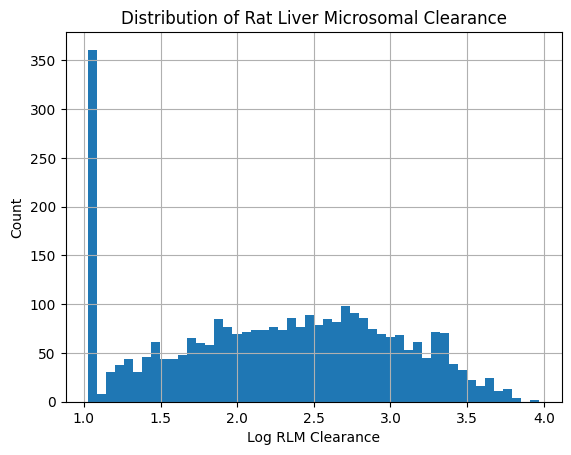

In [4]:
df['LOG RLM_CLint (mL/min/kg)'].hist(bins=50)
plt.xlabel('Log RLM Clearance')
plt.ylabel('Count')
plt.title('Distribution of Rat Liver Microsomal Clearance')
plt.show()

Matplotlib automatically excludes compounds with missing clearance values, so only rows with available RLM measurements are shown.

### Apparent Clearance Cut-Off in RLM Data

Inspection of the RLM clearance distribution reveals a high frequency of compounds with an identical log clearance value (~1.028).

This suggests the presence of an assay-imposed upper clearance limit, as also seen in the HLM data.

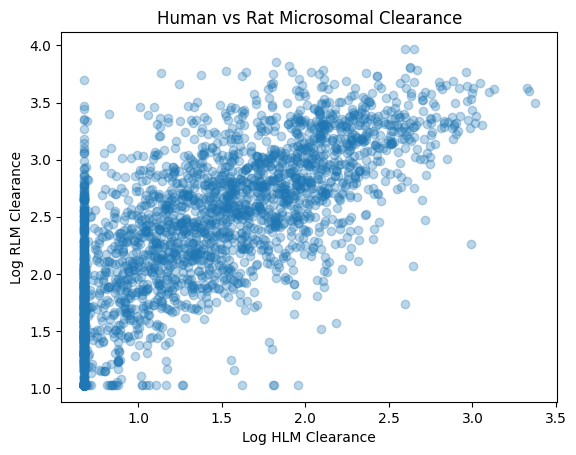

In [5]:
plt.scatter(
    df['LOG HLM_CLint (mL/min/kg)'],
    df['LOG RLM_CLint (mL/min/kg)'],
    alpha=0.3
)
plt.xlabel('Log HLM Clearance')
plt.ylabel('Log RLM Clearance')
plt.title('Human vs Rat Microsomal Clearance')
plt.show()

Matplotlib automatically excludes compounds with missing clearance values, so only rows with available HLM and RLM measurements are shown.

In [6]:
hlm_col = 'LOG HLM_CLint (mL/min/kg)'

df[hlm_col].value_counts().head(5)


LOG HLM_CLint (mL/min/kg)
0.675687    958
0.881385      6
1.738313      2
1.139060      2
1.527488      2
Name: count, dtype: int64

In [7]:
hlm_col = 'LOG HLM_CLint (mL/min/kg)'
HLM_CAP_VALUE = 0.675686709

df['HLM_is_capped'] = (
    df[hlm_col].notna() &
    (df[hlm_col] == HLM_CAP_VALUE)
)

hlm_n_total = df[hlm_col].notna().sum()
hlm_n_capped = df['HLM_is_capped'].sum()
hlm_pct_capped = (hlm_n_capped / hlm_n_total) * 100

hlm_n_total, hlm_n_capped, round(hlm_pct_capped, 1)

(np.int64(3087), np.int64(958), np.float64(31.0))

In [8]:
from IPython.display import Markdown, display

display(Markdown(f"""
### Identification of Capped HLM Clearance Values

A large proportion of compounds share an identical log HLM clearance value
(~0.676), suggesting the presence of an assay-imposed upper clearance limit.
To quantify this effect, the capped value was explicitly identified and flagged.

- **Total compounds with HLM data:** {hlm_n_total}
- **Compounds at apparent clearance cap:** {hlm_n_capped}
- **Percentage capped:** {hlm_pct_capped:.1f}%

A boolean flag (`HLM_is_capped`) was added to the dataset to identify these
entries without modifying the underlying measurements. This enables appropriate
handling of censored values in downstream analyses and modelling.
"""))


### Identification of Capped HLM Clearance Values

A large proportion of compounds share an identical log HLM clearance value
(~0.676), suggesting the presence of an assay-imposed upper clearance limit.
To quantify this effect, the capped value was explicitly identified and flagged.

- **Total compounds with HLM data:** 3087
- **Compounds at apparent clearance cap:** 958
- **Percentage capped:** 31.0%

A boolean flag (`HLM_is_capped`) was added to the dataset to identify these
entries without modifying the underlying measurements. This enables appropriate
handling of censored values in downstream analyses and modelling.


In [9]:
rlm_col = 'LOG RLM_CLint (mL/min/kg)'
RLM_CAP_VALUE = 1.027920136

df['RLM_is_capped'] = (
    df[rlm_col].notna() &
    (df[rlm_col] == RLM_CAP_VALUE)
)

rlm_n_total = df[rlm_col].notna().sum()
rlm_n_capped = df['RLM_is_capped'].sum()
rlm_pct_capped = (rlm_n_capped / rlm_n_total) * 100

rlm_n_total, rlm_n_capped, round(rlm_pct_capped, 1)

(np.int64(3054), np.int64(346), np.float64(11.3))

In [10]:
from IPython.display import Markdown, display

display(Markdown(f"""
### Identification of Capped RLM Clearance Values

A large proportion of compounds share an identical log RLM clearance value
(~1.028), suggesting the presence of an assay-imposed upper clearance limit.
To quantify this effect, the capped value was explicitly identified and flagged.

- **Total compounds with RLM data:** {rlm_n_total}
- **Compounds at apparent clearance cap:** {rlm_n_capped}
- **Percentage capped:** {rlm_pct_capped:.1f}%

A boolean flag (`RLM_is_capped`) was added to the dataset to identify these
entries without modifying the underlying measurements. This enables appropriate
handling of censored values in downstream analyses and modelling.
"""))


### Identification of Capped RLM Clearance Values

A large proportion of compounds share an identical log RLM clearance value
(~1.028), suggesting the presence of an assay-imposed upper clearance limit.
To quantify this effect, the capped value was explicitly identified and flagged.

- **Total compounds with RLM data:** 3054
- **Compounds at apparent clearance cap:** 346
- **Percentage capped:** 11.3%

A boolean flag (`RLM_is_capped`) was added to the dataset to identify these
entries without modifying the underlying measurements. This enables appropriate
handling of censored values in downstream analyses and modelling.
